# Tennis Stroke Classification: Model Development

### 0. Import PyTorch and Set Up Device Agnostic Code

In [1]:
import torch
from torch import nn

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

### 1. Data Preprocessing and Data Exploration

In [2]:
import os
def walkthrough_data(dir_path):
    """Walk through dir_path returning its contents"""
    for dir_path, dirnames, filenames in os.walk(dir_path):
        print(f"{len(dirnames)} directories and {len(filenames)} images in {dir_path}")

walkthrough_data('dataset')

2 directories and 0 images in dataset
4 directories and 0 images in dataset/train_set
0 directories and 375 images in dataset/train_set/forehand
0 directories and 375 images in dataset/train_set/backhand
0 directories and 375 images in dataset/train_set/serve
0 directories and 375 images in dataset/train_set/ready_position
4 directories and 0 images in dataset/test_set
0 directories and 125 images in dataset/test_set/forehand
0 directories and 125 images in dataset/test_set/backhand
0 directories and 125 images in dataset/test_set/serve
0 directories and 125 images in dataset/test_set/ready_position


In [3]:
#Training and test path
from pathlib import Path

image_path = Path("dataset")

train_dir = image_path / "train_set"
test_dir = image_path / "test_set"

train_dir, test_dir

(PosixPath('dataset/train_set'), PosixPath('dataset/test_set'))

### 2. Visualize Images using Matplotlib

Image Class: backhand, Image Height: 720, Image Width: 1280


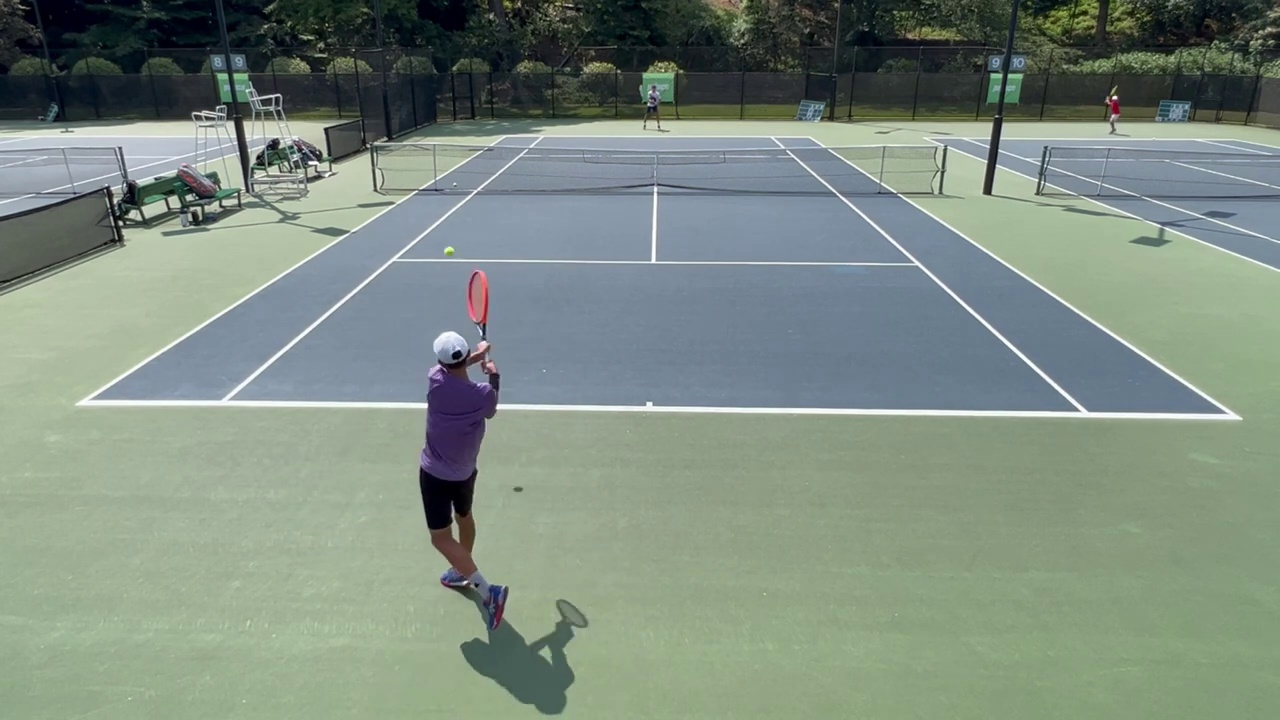

In [4]:
import random
from PIL import Image

# Set seed
random.seed(73)

image_path_list = list(image_path.glob("*/*/*.jpeg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f'Image Class: {image_class}, Image Height: {img.height}, Image Width: {img.width}')

img

(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

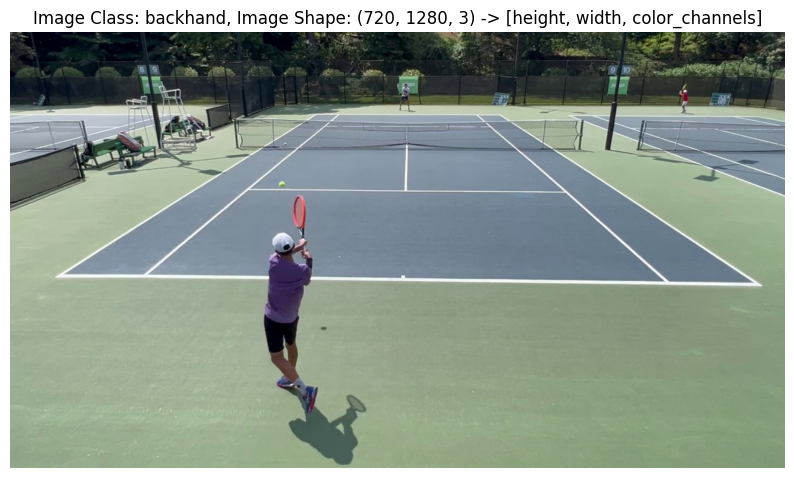

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Image to array
img_as_array = np.asarray(img)

#Plot
plt.figure(figsize = (10, 7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class}, Image Shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

### 3. Transforming Data into Tensors

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#Transforming data with torchvision.transforms
data_transform = transforms.Compose(
    [#Crop the center square
    transforms.CenterCrop(720),
    #Resize
    transforms.Resize(size = (128, 128)),
    #Turn the image into a torch tensor
    transforms.ToTensor()]
)

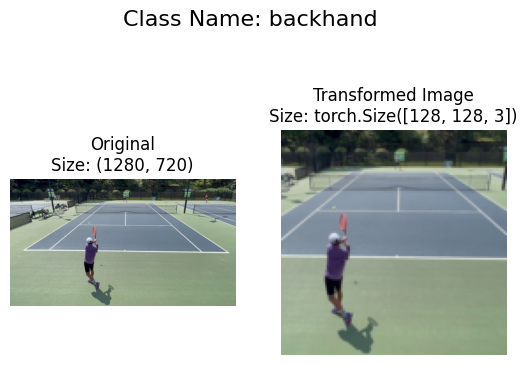

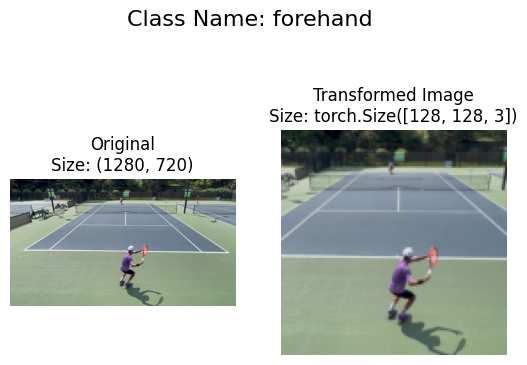

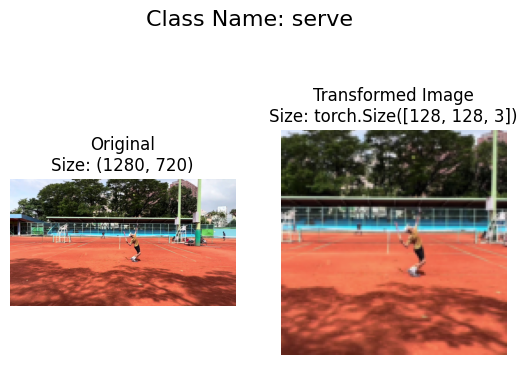

In [7]:
def plot_transformed_images(image_paths: list, transform, seed = 73, n = 3):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows = 1, ncols = 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed Image\nSize: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class Name: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_paths = image_path_list, transform = data_transform)

### 4. Loading image data using `ImageFolder`

In [8]:
from torchvision import datasets
train_data = datasets.ImageFolder(
    root = train_dir,
    transform = data_transform,
    target_transform = None
)

test_data = datasets.ImageFolder(
    root = test_dir,
    transform = data_transform,
)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 1500
     Root location: dataset/train_set
     StandardTransform
 Transform: Compose(
                CenterCrop(size=(720, 720))
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 500
     Root location: dataset/test_set
     StandardTransform
 Transform: Compose(
                CenterCrop(size=(720, 720))
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [9]:
class_names = train_data.classes
class_names

['backhand', 'forehand', 'ready_position', 'serve']

In [10]:
class_dict = train_data.class_to_idx
class_dict

{'backhand': 0, 'forehand': 1, 'ready_position': 2, 'serve': 3}

In [11]:
img, label = train_data[0][0], train_data[0][1]
img, label

(tensor([[[0.1647, 0.1020, 0.0863,  ..., 0.1490, 0.1608, 0.1961],
          [0.1490, 0.1020, 0.0784,  ..., 0.1333, 0.1412, 0.2000],
          [0.0863, 0.0941, 0.0667,  ..., 0.1255, 0.1255, 0.1529],
          ...,
          [0.5647, 0.5647, 0.5686,  ..., 0.5333, 0.5294, 0.5294],
          [0.5686, 0.5686, 0.5686,  ..., 0.5294, 0.5294, 0.5255],
          [0.5725, 0.5765, 0.5725,  ..., 0.5294, 0.5333, 0.5373]],
 
         [[0.2118, 0.1529, 0.1373,  ..., 0.1922, 0.2039, 0.2353],
          [0.2039, 0.1529, 0.1373,  ..., 0.1765, 0.1843, 0.2431],
          [0.1451, 0.1490, 0.1255,  ..., 0.1686, 0.1686, 0.1961],
          ...,
          [0.6471, 0.6471, 0.6471,  ..., 0.6275, 0.6275, 0.6235],
          [0.6510, 0.6510, 0.6510,  ..., 0.6275, 0.6235, 0.6196],
          [0.6549, 0.6588, 0.6549,  ..., 0.6275, 0.6275, 0.6235]],
 
         [[0.1765, 0.1216, 0.1137,  ..., 0.1490, 0.1608, 0.1882],
          [0.1608, 0.1216, 0.1098,  ..., 0.1373, 0.1490, 0.2039],
          [0.1255, 0.1294, 0.1137,  ...,

### 5. Turn loaded images into `DataLoader`'s

In [12]:
#Turn train and test data into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers = os.cpu_count(),
    shuffle = True,
    drop_last = True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    num_workers = os.cpu_count(),
    shuffle = False,
    drop_last = True
)

In [13]:
len(train_dataloader), len(test_dataloader)

(46, 15)

### 6. Creating a CNN Model

In [14]:
class TennisStrokeClassification(nn.Module):
    def __init__(self, num_classes: int = 4):
        super().__init__()
        """
        Formula for calculating change in pixel size is 
        out = [(in + 2(padding) - kernel) / stride] + 1
        """
        self.features = nn.Sequential(
            # [32, 3, 128, 128]
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(num_features = 32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 1),

            # [32, 32, 126, 126]
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 1),

            # [32, 64, 124, 124]
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            # [32, 128, 62, 62]
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            # [32, 256, 31, 31]
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            # [32, 512, 15, 15]
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))  # Pool it down to 8x8
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        if x.device.type == 'mps':
            x = x.to('cpu')
            x = self.adaptive_pool(x)
            x = x.to('mps')
        else:
            x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

In [15]:
tennis_stroke_model = TennisStrokeClassification()
tennis_stroke_model = tennis_stroke_model.to(device)

### 7. Creating Training and Testing Loop Functions

In [16]:
from torch.optim.lr_scheduler import StepLR
adam_optimizer = torch.optim.Adam(params = tennis_stroke_model.parameters(), lr = 0.001, weight_decay = 1e-4)

scheduler = StepLR(
    adam_optimizer,  
    step_size = 7,  
    gamma = 0.5    
)

loss_fn = nn.CrossEntropyLoss()

def accuracy_fn(pred, true):
    correct = torch.eq(pred, true).sum().item()
    return correct / len(pred) * 100

In [17]:
#train_step() takes the training dataloader, test_step() takes the testing dataloader
def train_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        seed: int, 
        loss_function: torch.nn.Module,
        optimization_function: torch.optim.Optimizer,
        accuracy_function,
):
    torch.manual_seed(seed)
    train_loss_total, train_acc_total = 0, 0
    for X_batch, y_batch in dataloader:
        # Move to best device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        model.train()
        # Forward pass
        y_train_preds_logits = model(X_batch)
        # Loss
        loss = loss_function(y_train_preds_logits, y_batch)
        train_loss_total += loss.item()
        # Backpropagation
        optimization_function.zero_grad()
        loss.backward()
        # Gradient Descent
        optimization_function.step()
        # Accuracy
        accuracy = accuracy_function(y_train_preds_logits.argmax(dim = 1), y_batch)
        train_acc_total += accuracy
    train_acc = train_acc_total / len(dataloader)
    train_loss = train_loss_total / len(dataloader)
    print(f"Train Loss: {train_loss} | Train Accuracy: {train_acc}")

def test_step(
        model: torch.nn.Module,
        loss_function: torch.nn.Module,
        seed: int,
        accuracy_function,
        dataloader: torch.utils.data.DataLoader
):
    torch.manual_seed(seed)
    test_loss_total, test_accuracy_total = 0, 0
    # Set to evaluation mode
    model.eval()
    with torch.inference_mode():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # Forward pass
            y_test_preds_logits = model(X_batch)
            # Loss
            loss = loss_function(y_test_preds_logits, y_batch)
            test_loss_total += loss.item()
            # Accuracy
            accuracy = accuracy_function(y_test_preds_logits.argmax(dim = 1), y_batch)
            test_accuracy_total += accuracy
        test_acc = test_accuracy_total / len(dataloader)
        test_loss = test_loss_total / len(dataloader)
        print(f"Test Loss: {test_loss} | Test Accuracy: {test_acc}")

In [18]:
# Wrap the test loop inside a function
def train_test_loop(
        model: torch.nn.Module,
        epochs: int,
        device,
        optimizer: torch.optim.Optimizer,
        scheduling_function: torch.optim.lr_scheduler,
        loss_function: torch.nn.Module
):
    model = model.to(device)
    for epoch in range(epochs):
        print(f"Epoch: {epoch} ==============================")
        train_step(
            model = model,
            dataloader = train_dataloader,
            seed = 73,
            loss_function = loss_function,
            optimization_function = optimizer,
            accuracy_function = accuracy_fn,
        )
        test_step(
            model = model,
            loss_function = loss_function,
            seed = 73,
            accuracy_function = accuracy_fn,
            dataloader = test_dataloader
        )
        scheduling_function.step()

train_test_loop(model = tennis_stroke_model, epochs = 50, device = device, optimizer = adam_optimizer, scheduling_function = scheduler, loss_function = loss_fn)

Epoch: 0 ==============================
Train Loss: 3.5293004422084144 | Train Accuracy: 46.39945652173913
Test Loss: 2.243110167204092 | Test Accuracy: 36.458333333333336
Epoch: 1 ==============================
Train Loss: 1.5062294446903726 | Train Accuracy: 59.171195652173914
Test Loss: 1.626087070008119 | Test Accuracy: 58.125
Epoch: 2 ==============================
Train Loss: 1.512384699738544 | Train Accuracy: 62.36413043478261
Test Loss: 2.419719863931338 | Test Accuracy: 43.333333333333336
Epoch: 3 ==============================
Train Loss: 1.3827965602926586 | Train Accuracy: 63.11141304347826
Test Loss: 1.552007395029068 | Test Accuracy: 60.833333333333336
Epoch: 4 ==============================
Train Loss: 1.2774524585060452 | Train Accuracy: 63.858695652173914
Test Loss: 1.4195680192516495 | Test Accuracy: 63.125
Epoch: 5 ==============================
Train Loss: 1.0935189412987751 | Train Accuracy: 66.23641304347827
Test Loss: 1.3123416199814528 | Test Accuracy: 64.79166

In [19]:
torch.save(tennis_stroke_model.state_dict(), "tennis_stroke_model.pth")